In [1]:
import numpy as np
from PIL import Image
import os
import cv2
import h5py
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TENSORFLOW_FLAGS"]  = "device=gpu"
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras import regularizers
import keras.models as models
from keras.utils import np_utils
from keras.layers import Reshape,Dense,Dropout,Activation,Flatten,GaussianNoise,Conv2D,MaxPooling2D,AveragePooling2D
from keras.regularizers import *
from keras.optimizers import adam
from keras.utils import to_categorical
from sklearn.decomposition import PCA
from keras.models import load_model

/home/subham/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
x = []
y = []

j = k = 1
arr = []
path = os.listdir('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Genuine/')
path.sort(key=str.lower)
path
t=1
j=0
for i in range(len(path)):
    img = cv2.imread('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Genuine/'+path[i]+'')
    img=cv2.resize(img,(512,256))
    img  = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #a = np.asarray(img)
    #a = Center(a,551,1117)
    idx=path[i].find('_')
    g=int(path[i][:idx])
    x.append(img)
    y1=np.zeros(10)
    y1[g-1]=1
    y.append(y1)
x11 = []
y11 = []

j = k = 1
arr = []
path = os.listdir('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Forgeries/')
path.sort(key=str.lower)

t=1
j=0
for i in range(len(path)):
    img = cv2.imread('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Forgeries/'+path[i]+'')
    p=path[i][4:]
    img=cv2.resize(img,(512,256))
    img  = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #a = np.asarray(img)
    #a = Center(a,551,1117)
    idx=p.find('_')
    g=int(p[:idx])
    x11.append(img)
    y1=np.zeros(10)
    y1[g-1]=1
    y11.append(y1)
x=np.array(x,dtype=np.float32)
y=np.array(y)
x11=np.array(x11,dtype=np.float32)
y11=np.array(y11)
y=np.concatenate((y,np.zeros(y.shape)),axis=1)
y11=np.concatenate((np.zeros(y11.shape),y11),axis=1)
x=np.concatenate((x,x11))
y=np.concatenate((y,y11))


In [3]:
print(len(x),len(y))
from matplotlib import pyplot as plt
plt.imshow(np.uint8(255-x[26]))
plt.figure();
plt.show();

575 575


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
x = (x-128)/255.0

x=x[...,np.newaxis]
in_shp=x[0].shape
classes=y.shape[1]
print(x.shape,y.shape)

X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.30, random_state=72,stratify=y)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=72,stratify=Y_val)
print(X_test.shape,Y_test.shape,np.max(x))
del x,y,x11,y11

(575, 256, 512, 1) (575, 20)
(87, 256, 512, 1) (87, 20) 0.49803922


In [5]:
print(np.argmax(Y_train,axis=1))
hist = np.unique(np.argmax(Y_train,axis=1))
print(hist)

[11  3  9 17 13  2 10 16  7 16 17  8 17 12 19 19  2  5 15 10 13  3 12  5
 17  7 12 16 11 18  1 12 10  5 10  5 10 17 10 19 10  1 10 17  9 12 13 13
  6 15  3 14  9  8 10  7 19  7 14  7  3  0  4 12  2  0  0 14 17  8 14  6
 18  2 19 18 12  0 15 13 14 12 14  9  3 17 14  7  0  8 15  9 16 14  5 11
  2 17  6 19  2 11 11  0 13 10 10 19  2  5 13  4 13  2  8 15 15  0 15  1
  3  4 17 14  8 18 18  9 19  2  6 12 16  6 11  5 19  0 12  8 11  0 17 13
 18 18 12 16  1 18 16  6  9  9 19 13  3  1 14 11 14 18 15  0  5  1 13 11
 12 12 15 18 14  7 11  3  1 16 16 13  7  0  8  5 18 11  5  4  6 18 15  5
  2 10  1 13 15  0 10 17 13 10  7  7  7 13  9  4  7 15 12 11 16 16 15 17
  6 16 14  6 18 15 18 16 18  5  8 12 14 17 13 13  9 10 14 11 11 14 12  4
  4  8 19 18 15 17  2 12 16 18  9  8  0 11  1 18  3 16 16 14  6  6 17 16
 11  3 10 17 16  1  2  4 12 14 12 15 14  3  0 13 11  6  5 18 16 15  5  9
 17 15  1  8  6 16 15  3 14 11 16 17  6 16 19  3 16 11  7 10 17 16  2 10
 18 13 18 10 11  6  2 11 14 17  8  4  3 18 17 11 13

In [6]:
dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Conv2D(64, (11,11), activation='relu',strides=4, name='conv1', padding='same', kernel_initializer='glorot_uniform', input_shape=in_shp))
model.add(Dropout(dr))
model.add(MaxPooling2D(pool_size=(5, 5), strides=2, padding='valid', data_format=None))
model.add(Conv2D(96, (9, 9), activation='relu', name='conv2', padding='same', kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(MaxPooling2D(pool_size=(5, 5), strides=2, padding='valid', data_format=None))
model.add(Conv2D(128, (3, 3), activation='relu', name='conv3', padding='same', kernel_initializer='glorot_uniform'))
model.add(Conv2D(128, (3, 3), activation='relu', name='conv4', padding='same', kernel_initializer='glorot_uniform'))
model.add(Conv2D(128, (3, 3), activation='relu', name='conv5', padding='same', kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid', data_format=None))
model.add(Flatten())
model.add(Dense(256, activation='relu', name='dense1', kernel_initializer='he_normal'))
model.add(Dropout(dr))
model.add(Dense(128, activation='relu', name='dense2', kernel_initializer='he_normal'))
model.add(Dropout(dr))
model.add(Dense(classes, name='dense3', kernel_initializer='he_normal'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 128, 64)       7808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 128, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 62, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 62, 96)        497760    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 62, 96)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 29, 96)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 29, 128)       110720    
__________

In [7]:
nb_epoch = 200     # number of epochs to train on
batch_size = 32 # training batch size

In [8]:
filepath = 'Model_A_wts_data2.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    #show_accuracy=False,
#     verbose=2,
    validation_data=(X_val, Y_val),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 402 samples, validate on 86 samples
Epoch 1/200
402/402 [==============================] - 6s 14ms/step - loss: 3.2562 - acc: 0.0647 - val_loss: 2.9860 - val_acc: 0.0581
Epoch 2/200
402/402 [==============================] - 2s 5ms/step - loss: 2.9894 - acc: 0.0498 - val_loss: 2.9687 - val_acc: 0.0814
Epoch 3/200
402/402 [==============================] - 2s 5ms/step - loss: 2.8783 - acc: 0.1119 - val_loss: 2.9376 - val_acc: 0.2326
Epoch 4/200
402/402 [==============================] - 2s 5ms/step - loss: 2.7144 - acc: 0.1542 - val_loss: 2.7953 - val_acc: 0.2558
Epoch 5/200
402/402 [==============================] - 2s 5ms/step - loss: 2.4980 - acc: 0.2289 - val_loss: 2.6817 - val_acc: 0.3605
Epoch 6/200
402/402 [==============================] - 2s 5ms/step - loss: 2.1894 - acc: 0.3035 - val_loss: 2.6366 - val_acc: 0.3953
Epoch 7/200
402/402 [==============================] - 2s 5ms/step - loss: 1.9053 - acc: 0.4030 - val_loss: 2.3319 - val_acc: 0.5698
Epoch 8/200
402/402 [==

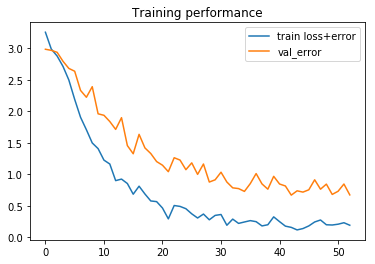

In [9]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.savefig('Training_Performance_Model_C_90classes_DOST.jpg',dpi=300,transparent=True)

In [10]:
Y_pred=model.predict(X_test)
print(X_test.shape,Y_test.shape)
hist = np.unique(np.argmax(Y_test,axis=1))
print(hist)

(87, 256, 512, 1) (87, 20)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [11]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

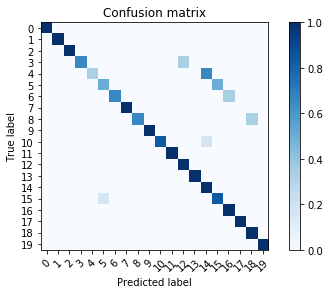

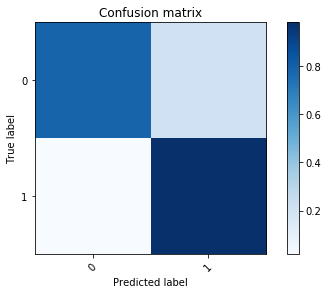

In [12]:
conf1=np.zeros([Y_test.shape[1],Y_test.shape[1]])
conf2=np.zeros([2,2])
classes=np.array(range(0,20))
for i in range(0,Y_test.shape[0]):
    j=np.argmax(Y_test[i])
    k=np.argmax(Y_pred[i])
    conf1[j,k]=conf1[j,k]+1
    conf2[j//10,k//10]=conf2[j//10,k//10]+1
for i in range(0,classes.shape[0]):
    conf1[i,:] = (conf1[i,:] / np.sum(conf1[i,:]))
for i in range(0,2):
    conf2[i,:] = (conf2[i,:] / np.sum(conf2[i,:]))
plot_confusion_matrix(conf1, labels=classes)
plt.figure()
plot_confusion_matrix(conf2, labels=[0,1])

In [13]:
model1 = models.Sequential()
model1.add(Conv2D(64, (11,11), activation='relu',strides=4, name='conv1', padding='same', kernel_initializer='glorot_uniform', input_shape=in_shp))
model1.add(MaxPooling2D(pool_size=(5, 5), strides=2, padding='valid', data_format=None))
model1.add(Conv2D(96, (9, 9), activation='relu', name='conv2', padding='same', kernel_initializer='glorot_uniform'))
model1.add(MaxPooling2D(pool_size=(5, 5), strides=2, padding='valid', data_format=None))
model1.add(Conv2D(128, (3, 3), activation='relu', name='conv3', padding='same', kernel_initializer='glorot_uniform'))
model1.add(Conv2D(128, (3, 3), activation='relu', name='conv4', padding='same', kernel_initializer='glorot_uniform'))
model1.add(Conv2D(128, (3, 3), activation='relu', name='conv5', padding='same', kernel_initializer='glorot_uniform'))
model1.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid', data_format=None))
model1.add(Flatten())
model1.add(Dense(256, activation='relu', name='dense1', kernel_initializer='he_normal'))
model1.add(Dense(128, activation='relu', name='dense2', kernel_initializer='he_normal'))
model1.load_weights('Model_A_wts_data2.h5', by_name=True)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 128, 64)       7808      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 62, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 62, 96)        497760    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 29, 96)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 29, 128)       110720    
_________________________________________________________________
conv4 (Conv2D)               (None, 13, 29, 128)       147584    
_________________________________________________________________
conv5 (Conv2D)               (None, 13, 29, 128)       147584    
__________

In [14]:
x_out=np.array(X_test[0])
x_out=x_out[np.newaxis,...]
y_out=model1.predict(X_train)
print(y_out.shape,X_train.shape)

(402, 128) (402, 256, 512, 1)


original shape:    (402, 128)
transformed shape: (402, 2)


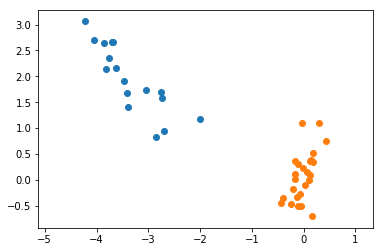

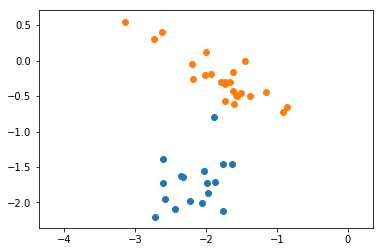

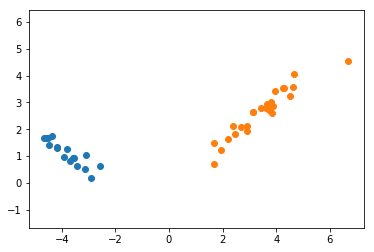

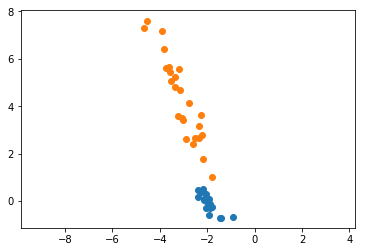

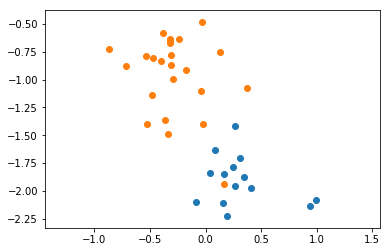

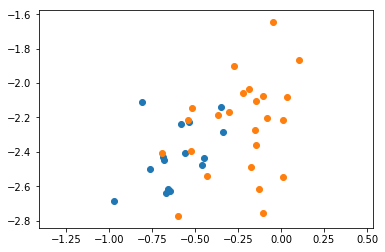

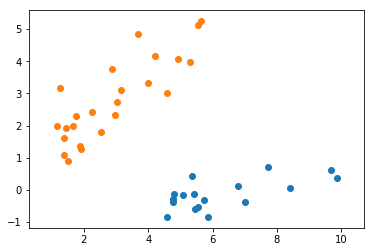

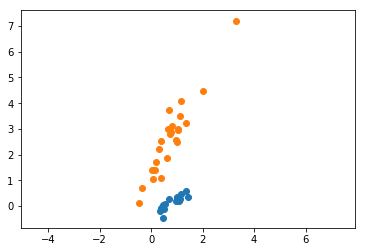

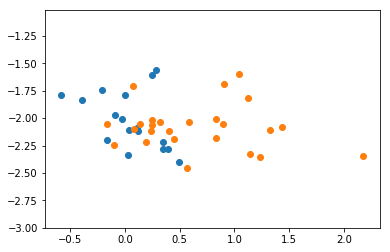

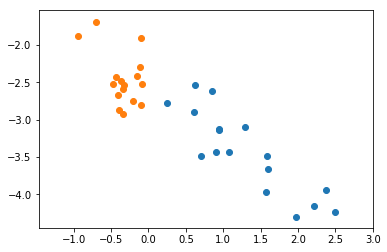

<Figure size 432x288 with 0 Axes>

In [15]:
pca = PCA(n_components=2)
pca.fit(y_out)
X_pca = pca.transform(y_out)
print("original shape:   ", y_out.shape)
print("transformed shape:", X_pca.shape)
for j in range(0,10):
    y_out1 = []
    y_out2 = []
    for i in range(0,y_out.shape[0]):
        if (np.argmax(Y_train[i]))==(0+j):
            y_out1.append(X_pca[i])
        elif (np.argmax(Y_train[i]))==(10+j):
            y_out2.append(X_pca[i])
    y_out1=np.array(y_out1)
    y_out2=np.array(y_out2)
    plt.scatter(y_out1[:, 0], y_out1[:, 1])
    plt.scatter(y_out2[:, 0], y_out2[:, 1])
    plt.axis('equal');
    plt.figure()

<Figure size 432x288 with 0 Axes>

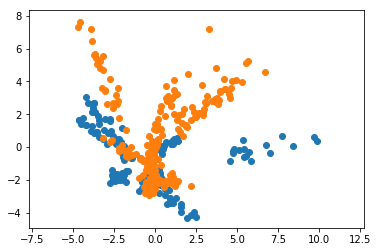

<Figure size 432x288 with 0 Axes>

In [16]:
y_out1 = []
y_out2 = []
for i in range(0,y_out.shape[0]):
    if (np.argmax(Y_train[i])//10)==(0):
        y_out1.append(X_pca[i])
    elif (np.argmax(Y_train[i])//10)==(1):
        y_out2.append(X_pca[i])
y_out1=np.array(y_out1)
y_out2=np.array(y_out2)
plt.scatter(y_out1[:, 0], y_out1[:, 1])
plt.scatter(y_out2[:, 0], y_out2[:, 1])
plt.axis('equal');
plt.figure()